In [ ]:
import random
from collections import defaultdict
import numpy as np
from datetime import datetime
import sys
import os
import time
import shutil

import imageio

from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image

import matplotlib.pyplot as plt
plt.style.use(['science', 'ieee', 'no-latex'])


In [40]:
from __future__ import print_function

from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#!pip install keras-resnet
from keras_resnet.models import ResNet50
from keras.layers import Input
# from scipy.misc import imsave

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [41]:
model_layer_weights_top_k = []

In [42]:
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    input_img_data = tf.keras.preprocessing.image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data

In [43]:
def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [44]:

def decode_label(pred):
    return decode_predictions(pred)[0][0][1]

In [45]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


In [46]:
def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads

In [47]:
def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = 1e4 * np.mean(gradients)
    return grad_mean * new_grads

In [48]:

def constraint_black(gradients, rect_shape=(10, 10)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads

In [49]:
def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3

In [50]:
def init_coverage_tables(model1):
    model_layer_dict1 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    return model_layer_dict1

In [51]:
def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False

In [52]:
def init_coverage_times(model):
    model_layer_times = defaultdict(int)
    init_times(model,model_layer_times)
    return model_layer_times

In [53]:
def init_coverage_value(model):
    model_layer_value = defaultdict(float)
    init_times(model, model_layer_value)
    return model_layer_value

In [54]:
def init_times(model,model_layer_times):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_times[(layer.name, index)] = 0

In [55]:
def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in model_layer_dict.items() if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(model_layer_dict.keys())
    return layer_name, index

In [56]:
def neuron_to_cover(not_covered,model_layer_dict):
    if not_covered:
        layer_name, index = random.choice(not_covered)
        not_covered.remove((layer_name, index))
    else:
        layer_name, index = random.choice(model_layer_dict.keys())
    return layer_name, index

In [57]:
def random_strategy(model,model_layer_times, neuron_to_cover_num):
    loss_neuron = []
    not_covered = [(layer_name, index) for (layer_name, index), v in model_layer_times.items() if v == 0]
    for _ in range(neuron_to_cover_num):
        layer_name, index = neuron_to_cover(not_covered, model_layer_times)
        loss00_neuron = K.mean(model.get_layer(layer_name).output[..., index])
        loss_neuron.append(loss00_neuron)
    return loss_neuron

In [58]:
def neuron_select_high_weight(model, layer_names, top_k):
    global model_layer_weights_top_k
    model_layer_weights_dict = {}
    for layer_name in layer_names:
        weights = model.get_layer(layer_name).get_weights()
        if len(weights) <= 0:
            continue
        w = np.asarray(weights[0])  # 0 is weights, 1 is biases
        w = w.reshape(w.shape)
        for index in range(model.get_layer(layer_name).output_shape[-1]):
            index_w = np.mean(w[..., index])
            if index_w <= 0:
                continue
            model_layer_weights_dict[(layer_name,index)]=index_w
    # notice!
    model_layer_weights_list = sorted(model_layer_weights_dict.items(), key=lambda x: x[1], reverse=True)

    k = 0
    for (layer_name, index),weight in model_layer_weights_list:
        if k >= top_k:
            break
        model_layer_weights_top_k.append([layer_name,index])
        k += 1

In [59]:
def neuron_selection(model, model_layer_times, model_layer_value, neuron_select_strategy, neuron_to_cover_num,threshold):
    if neuron_select_strategy == 'None':
        return random_strategy(model, model_layer_times, neuron_to_cover_num)

    num_strategy = len([x for x in neuron_select_strategy if x in ['0', '1', '2', '3']])

    neuron_to_cover_num_each = neuron_to_cover_num / num_strategy

    loss_neuron = []
    # initialization for strategies
    if ('0' in list(neuron_select_strategy)) or ('1' in list(neuron_select_strategy)):
        i = 0
        neurons_covered_times = []
        neurons_key_pos = {}
        for (layer_name, index), time in model_layer_times.items():
            neurons_covered_times.append(time)
            neurons_key_pos[i] = (layer_name, index)
            i += 1
        neurons_covered_times = np.asarray(neurons_covered_times)
        times_total = sum(neurons_covered_times)

    # select neurons covered often
    if '0' in list(neuron_select_strategy):
        if times_total == 0:
            return random_strategy(model, model_layer_times, 1)#The beginning of no neurons covered
        neurons_covered_percentage = neurons_covered_times / float(times_total)
        num_neuron0 = np.random.choice(range(len(neurons_covered_times)), int(neuron_to_cover_num_each), replace=False, p=neurons_covered_percentage)
        for num in num_neuron0:
            layer_name0, index0 = neurons_key_pos[num]
            loss0_neuron = K.mean(model.get_layer(layer_name0).output[..., index0])
            loss_neuron.append(loss0_neuron)

    # select neurons covered rarely
    if '1' in list(neuron_select_strategy):
        if times_total == 0:
            return random_strategy(model, model_layer_times, 1)
        neurons_covered_times_inverse = np.subtract(max(neurons_covered_times), neurons_covered_times)
        neurons_covered_percentage_inverse = neurons_covered_times_inverse / float(sum(neurons_covered_times_inverse))
        # num_neuron1 = np.random.choice(range(len(neurons_covered_times)), p=neurons_covered_percentage_inverse)
        num_neuron1 = np.random.choice(range(len(neurons_covered_times)), int(neuron_to_cover_num_each), replace=False,
                                       p=neurons_covered_percentage_inverse)
        for num in num_neuron1:
            layer_name1, index1 = neurons_key_pos[num]
            loss1_neuron = K.mean(model.get_layer(layer_name1).output[..., index1])
            loss_neuron.append(loss1_neuron)

    # select neurons with largest weights (feature maps with largest filter weights)
    if '2' in list(neuron_select_strategy):
        layer_names = [layer.name for layer in model.layers if
                       'flatten' not in layer.name and 'input' not in layer.name]
        k = 0.1
        top_k = k * len(model_layer_times)  # number of neurons to be selected within
        global model_layer_weights_top_k
        if len(model_layer_weights_top_k) == 0:
            neuron_select_high_weight(model, layer_names, top_k)  # Set the value
        num_neuron2 = np.random.choice(range(len(model_layer_weights_top_k)), int(neuron_to_cover_num_each), replace=False)
        for i in num_neuron2:
            layer_name2 = model_layer_weights_top_k[i][0]
            index2 = model_layer_weights_top_k[i][1]
            loss2_neuron = K.mean(model.get_layer(layer_name2).output[..., index2])
            loss_neuron.append(loss2_neuron)

    if '3' in list(neuron_select_strategy):
        above_threshold = []
        below_threshold = []
        above_num = neuron_to_cover_num_each / 2
        below_num = neuron_to_cover_num_each - above_num
        above_i = 0
        below_i = 0
        for (layer_name, index), value in model_layer_value.items():
            if threshold + 0.25 > value > threshold and layer_name != 'fc1' and layer_name != 'fc2' and \
                    layer_name != 'predictions' and layer_name != 'fc1000' and above_i < above_num:
                above_threshold.append([layer_name, index])
                above_i += 1
            elif threshold > value > threshold - 0.2 and layer_name != 'fc1' and layer_name != 'fc2' and \
                    layer_name != 'predictions' and layer_name != 'fc1000' and below_i < below_num:
                below_threshold.append([layer_name, index])
                below_i += 1

        loss_neuron = []
        if len(above_threshold) > 0:
            for above_item in range(len(above_threshold)):
                loss_neuron.append(K.mean(
                    model.get_layer(above_threshold[above_item][0]).output[..., above_threshold[above_item][1]]))

        if len(below_threshold) > 0:
            for below_item in range(len(below_threshold)):
                loss_neuron.append(-K.mean(
                    model.get_layer(below_threshold[below_item][0]).output[..., below_threshold[below_item][1]]))

        if loss_neuron == 0:
            return random_strategy(model, model_layer_times, 1)  # The beginning of no neurons covered

    return loss_neuron

In [60]:
def neuron_scale(loss_neuron):
    loss_neuron_new = []
    loss_sum = K.sum(loss_neuron)
    for loss_each in loss_neuron:
        loss_each /= loss_sum
        loss_neuron_new.append(loss_each)
    return loss_neuron_new

In [61]:
def neuron_scale_maxmin(loss_neuron):
    max_loss = K.max(loss_neuron)
    min_loss = K.min(loss_neuron)
    base = max_loss - min_loss
    loss_neuron_new = []
    for loss_each in loss_neuron:
        loss_each_new = (loss_each - min_loss) / base
        loss_neuron_new.append(loss_each_new)
    return loss_neuron_new

In [62]:
def neuron_covered(model_layer_times):
    covered_neurons = len([v for v in model_layer_times.values() if v > 0])
    total_neurons = len(model_layer_times)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)

In [63]:
def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled

Instead of NC use and test KMNC, NBC, SNAC and TKNC


In [64]:
def update_coverage(input_data, model, model_layer_times, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        # xrange(scaled.shape[-1])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold: #and model_layer_dict[(layer_names[i], num_neuron)] == 0:
                model_layer_times[(layer_names[i], num_neuron)] += 1

    return intermediate_layer_outputs

In [65]:
def update_coverage_value(input_data, model, model_layer_value):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        # xrange(scaled.shape[-1])
        for num_neuron in range(scaled.shape[-1]):
            model_layer_value[(layer_names[i], num_neuron)] = np.mean(scaled[..., num_neuron])

    return intermediate_layer_outputs

In [66]:
def full_coverage(model_layer_dict):
    if False in model_layer_dict.values():
        return False
    return True

In [67]:
def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False

In [68]:
def diverged(predictions1, predictions2, predictions3, target):
    if not predictions1 == predictions2 == predictions3:
        return True
    return False

In [69]:
def get_signature():
    now = datetime.now()
    past = datetime(2015, 6, 6, 0, 0, 0, 0)
    timespan = now - past
    time_sig = int(timespan.total_seconds() * 1000)

    return str(time_sig)

# main program

example input

In [70]:
# [2] 0.25 10 0602 3 vgg16

inputs

In [71]:
# e.g.[0,1,2] None for neurons not covered, 0 for covered often, 1 for covered rarely, 2 for high weights
neuron_select_strategy = '1'
threshold = float(0.25)
neuron_to_cover_num = int(10)
iteration_times = int(1)
model_name = 'vgg16'
perturb_levels = [0.25, 0.5, 1, 2, 4]

In [72]:
# input image dimensions
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)

# load multiple models sharing same input tensor
K.set_learning_phase(0)

if model_name == 'vgg16':
    model1 = VGG16(input_tensor=input_tensor)
elif model_name == 'vgg19':
    model1 = VGG19(input_tensor=input_tensor)
elif model_name == 'resnet50':
    model1 = ResNet50(input_tensor=input_tensor)
else:
    print('please specify model name')
    os._exit(0)

print(model1.name)

vgg16


In [73]:
img_dir = 'ImageNet/seeds_20/'
img_paths = os.listdir(img_dir)
img_num = len(img_paths)

predict_weight = 0.5
neuron_to_cover_weight = 0.5
learning_step = 0.5

cov_dict = {}

# for perturb_level in perturb_levels:
coverage = []
# model_layer_dict1 = init_coverage_tables(model1)
model_layer_times1 = init_coverage_times(model1)  # times of each neuron covered
model_layer_times2 = init_coverage_times(model1)  # update when new image and adversarial images found
model_layer_value1 = init_coverage_value(model1)

for perturb_level in perturb_levels:
    perturb_level_tmp = str(perturb_level)
    perturb_level_tmp = perturb_level_tmp.replace(".", "_")
    save_dir = 'ImageNet/generated_inputs/' + "perturb_level_" + perturb_level_tmp + '/'

    """if os.path.exists(save_dir+'perturb/'):
        for i in os.listdir(save_dir+'perturb/'):
            path_file = os.path.join(save_dir+'perturb/', i)
            if os.path.isfile(path_file):
                os.remove(path_file)
    if os.path.exists(save_dir+'gen_img/'):
        for i in os.listdir(save_dir+'gen_img/'):
            path_file = os.path.join(save_dir+'gen_img/', i)
            if os.path.isfile(path_file):
                os.remove(path_file)"""
    if os.path.exists(save_dir+'random_img/'):
        for i in os.listdir(save_dir+'random_img/'):
            path_file = os.path.join(save_dir+'random_img/', i)
            if os.path.isfile(path_file):
                os.remove(path_file)
    if os.path.exists(save_dir+'random_perturb/'):
        for i in os.listdir(save_dir+'random_perturb/'):
            path_file = os.path.join(save_dir+'random_perturb/', i)
            if os.path.isfile(path_file):
                os.remove(path_file)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    """if not os.path.exists(save_dir+'perturb/'):
        os.makedirs(save_dir+'perturb/')
    if not os.path.exists(save_dir+'gen_img/'):
        os.makedirs(save_dir+'gen_img/')"""
    if not os.path.exists(save_dir+'random_img/'):
        os.makedirs(save_dir+'random_img/')
    if not os.path.exists(save_dir+'random_perturb/'):
        os.makedirs(save_dir+'random_perturb/')

    # start = time.clock()
    total_time = 0
    total_norm = 0
    adversial_num = 0
    total_perturb_adversial = 0

    for i in range(img_num):
        start_time = time.perf_counter()
        img_list = []
        img_path = os.path.join(img_dir,img_paths[i])
        print(img_path)
        tmp_img = preprocess_image(img_path)
        orig_img = tmp_img.copy()
        img_list.append(tmp_img)
        update_coverage(tmp_img, model1, model_layer_times2, threshold)
        while len(img_list) > 0:
            gen_img = img_list[0]
            img_list.remove(gen_img)

            # first check if input already induces differences
            pred1 = model1.predict(gen_img)
            label1 = np.argmax(pred1[0])

            label_top5 = np.argsort(pred1[0])[-5:]

            update_coverage_value(gen_img, model1, model_layer_value1)
            update_coverage(gen_img, model1, model_layer_times1, threshold)

            orig_label = label1
            orig_pred = pred1

            if model1.name == 'resnet50':
                loss_1 = K.mean(model1.get_layer('fc1000').output[..., orig_label])
                loss_2 = K.mean(model1.get_layer('fc1000').output[..., label_top5[-2]])
                loss_3 = K.mean(model1.get_layer('fc1000').output[..., label_top5[-3]])
                loss_4 = K.mean(model1.get_layer('fc1000').output[..., label_top5[-4]])
                loss_5 = K.mean(model1.get_layer('fc1000').output[..., label_top5[-5]])

            else:
                loss_1 = K.mean(model1.get_layer('predictions').output[..., orig_label])
                loss_2 = K.mean(model1.get_layer('predictions').output[..., label_top5[-2]])
                loss_3 = K.mean(model1.get_layer('predictions').output[..., label_top5[-3]])
                loss_4 = K.mean(model1.get_layer('predictions').output[..., label_top5[-4]])
                loss_5 = K.mean(model1.get_layer('predictions').output[..., label_top5[-5]])

            layer_output = (predict_weight * (loss_2 + loss_3 + loss_4 + loss_5) - loss_1)

            # neuron coverage loss
            loss_neuron = neuron_selection(model1, model_layer_times1, model_layer_value1, neuron_select_strategy, neuron_to_cover_num, threshold)

            # extreme value means the activation value for a neuron can be as high as possible ...
            EXTREME_VALUE = False
            if EXTREME_VALUE:
                neuron_to_cover_weight = 2

            layer_output += neuron_to_cover_weight * K.sum(loss_neuron)

            # for adversarial image generation
            final_loss = K.mean(layer_output)

            # we compute the gradient of the input picture wrt this loss
            grads = normalize(K.gradients(final_loss, input_tensor)[0])

            grads_tensor_list = [loss_1, loss_2, loss_3, loss_4, loss_5]
            grads_tensor_list.extend(loss_neuron)
            grads_tensor_list.append(grads)
            # this function returns the loss and grads given the input picture

            iterate = K.function([input_tensor], grads_tensor_list)

            # we run gradient ascent for some steps
            for iters in range(iteration_times):
                loss_neuron_list = iterate([gen_img])
                perturb = loss_neuron_list[-1] * learning_step  * perturb_level
                
                
                mean = np.mean(perturb)
                std = np.std(perturb)
                random_perturb = np.random.normal(mean, std, perturb.shape)
                # print(noise)
                # random_img = gen_img + random_perturb

                gen_img += random_perturb


                # previous accumulated neuron coverage
                previous_coverage = neuron_covered(model_layer_times1)[2]

                pred1 = model1.predict(gen_img)
                label1 = np.argmax(pred1[0])

                update_coverage(gen_img, model1, model_layer_times1, threshold) # for seed selection
                current_coverage = neuron_covered(model_layer_times1)[2]
                diff_img = gen_img - orig_img
                L2_norm = np.linalg.norm(diff_img)
                orig_L2_norm = np.linalg.norm(orig_img)
                perturb_adversial = L2_norm / orig_L2_norm

                if current_coverage - previous_coverage > 0.01 / (i + 1) and perturb_adversial < 0.02:
                    img_list.append(gen_img)
                    # print('coverage diff = ', current_coverage - previous_coverage, 'perturb_adversial = ', perturb_adversial)

                #if label1 != orig_label:
                update_coverage(gen_img, model1, model_layer_times2, threshold)
                total_norm += L2_norm
                total_perturb_adversial += perturb_adversial

                # print('L2 norm : ' + str(L2_norm))
                # print('ratio perturb = ', perturb_adversial)

                # get original image id
                _img_path = img_paths[i].split('_')
                _img_path = _img_path[-1]   # 00000xxx.JPEG
                _img_path = _img_path.split('.')
                _img_id = _img_path[0]    # 000000xxx


                """perturb_tmp = perturb.copy()
                perturb_deprocessed = deprocess_image(perturb_tmp)
                save_img = save_dir + 'perturb/' + _img_id + '_' +  decode_label(pred1) + '_' + decode_label(orig_pred) + '_' + str(get_signature()) + '.png'
                imageio.imwrite(save_img, perturb_deprocessed)

                gen_img_tmp = gen_img.copy()
                gen_img_deprocessed = deprocess_image(gen_img_tmp)
                save_img = save_dir + 'gen_img/' + _img_id + '_' + decode_label(pred1) + '_' + decode_label(orig_pred) + '_' + str(get_signature()) + '.png'
                # imsave(save_img, gen_img_deprocessed)
                imageio.imwrite(save_img, gen_img_deprocessed)
                """
                #for perturb_level in perturb_levels:
                # perturb_level_tmp = str(perturb_level)
                #perturb_level_tmp = perturb_level_tmp.replace(".", "_")
                #save_dir = 'ImageNet/generated_inputs/' + "perturb_level_" + perturb_level_tmp + '/'

                random_perturb_tmp = random_perturb.copy()
                random_perturb_deprocessed = deprocess_image(random_perturb_tmp)
                save_img = save_dir + 'random_perturb/' + _img_id + '_' +  decode_label(pred1) + '_' + decode_label(orig_pred) + '_' + str(get_signature()) + '.png'
                imageio.imwrite(save_img, random_perturb_deprocessed)

                random_img_tmp = gen_img.copy()
                random_img_deprocessed = deprocess_image(random_img_tmp)
                save_img = save_dir + 'random_img/' + _img_id + '_' + decode_label(pred1) + '_' + decode_label(orig_pred) + '_' + str(get_signature()) + '.png'
                # imsave(save_img, gen_img_deprocessed)
                imageio.imwrite(save_img, random_img_deprocessed)

                adversial_num += 1

        end_time = time.perf_counter()
        print('covered neurons percentage %d neurons %.3f'
              % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))
        duration = end_time - start_time
        print('used time : ' + str(duration))
        total_time += duration
        print('__________________________________')
        coverage.append(neuron_covered(model_layer_times2)[2])
    cov_dict[str(perturb_level)] = coverage  

    #print('final covered neurons percentage %d neurons %.3f'% (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))
    #print('total_time = ' + str(total_time))
    #print('average_norm = ' + str(total_norm / adversial_num))
    #print('adversial num = ' + str(adversial_num))
    #print('average perb adversial = ' + str(total_perturb_adversial / adversial_num))
    #print('__________________________________')
    print(cov_dict)

ImageNet/seeds_20/ILSVRC2012_test_00000055.JPEG
covered neurons percentage 14888 neurons 0.050
used time : 16.717482000000018
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000100.JPEG
covered neurons percentage 14888 neurons 0.081
used time : 14.231414600000107
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000227.JPEG
covered neurons percentage 14888 neurons 0.137
used time : 14.913140500000054
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000329.JPEG
covered neurons percentage 14888 neurons 0.167
used time : 14.540559999999914
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000380.JPEG
covered neurons percentage 14888 neurons 0.202
used time : 15.310081800000034
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000505.JPEG
covered neurons percentage 14888 neurons 0.226
used time : 15.229793100000052
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_

covered neurons percentage 14888 neurons 0.442
used time : 19.37285759999986
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000100.JPEG
covered neurons percentage 14888 neurons 0.442
used time : 19.962676600000123
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000227.JPEG
covered neurons percentage 14888 neurons 0.443
used time : 21.992605699999785
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000329.JPEG
covered neurons percentage 14888 neurons 0.443
used time : 20.349661300000207
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000380.JPEG
covered neurons percentage 14888 neurons 0.443
used time : 20.95690579999973
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000505.JPEG
covered neurons percentage 14888 neurons 0.443
used time : 20.51771770000005
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000517.JPEG
covered neurons percentage 14888 neur

covered neurons percentage 14888 neurons 0.444
used time : 24.84438880000016
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00001248.JPEG
covered neurons percentage 14888 neurons 0.444
used time : 25.24787970000034
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00001296.JPEG
covered neurons percentage 14888 neurons 0.444
used time : 26.349654699999974
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00001442.JPEG
covered neurons percentage 14888 neurons 0.444
used time : 26.146984500000144
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00001582.JPEG
covered neurons percentage 14888 neurons 0.444
used time : 26.532175400000142
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00001810.JPEG
covered neurons percentage 14888 neurons 0.444
used time : 26.668642199999795
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00001890.JPEG
covered neurons percentage 14888 neu

covered neurons percentage 14888 neurons 0.445
used time : 26.1425720000002
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000100.JPEG
covered neurons percentage 14888 neurons 0.445
used time : 28.098225100000036
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000227.JPEG
covered neurons percentage 14888 neurons 0.446
used time : 27.609511799999837
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000329.JPEG
covered neurons percentage 14888 neurons 0.446
used time : 27.71107400000028
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000380.JPEG
covered neurons percentage 14888 neurons 0.447
used time : 27.990905099999964
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000505.JPEG
covered neurons percentage 14888 neurons 0.447
used time : 26.669181800000388
__________________________________
ImageNet/seeds_20/ILSVRC2012_test_00000517.JPEG
covered neurons percentage 14888 neur

In [74]:
print(cov_dict)

{'0.25': [0.050107469102632994, 0.08127350886620097, 0.13722461042450296, 0.16650994089199356, 0.20237775389575496, 0.22649113379903277, 0.25947071466953253, 0.2894277270284793, 0.3109215475550779, 0.332684040838259, 0.35061794734013974, 0.3633799032778076, 0.3747313272434175, 0.3883664696399785, 0.3987775389575497, 0.4039494895217625, 0.41812197743148843, 0.4269881783987104, 0.4363245566899516, 0.442101020956475, 0.442101020956475, 0.442101020956475, 0.4421681891456206, 0.4421681891456206, 0.4421681891456206, 0.4421681891456206, 0.4421681891456206, 0.4421681891456206, 0.4421681891456206, 0.44230252552391186, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.4423696937130575, 0.44250403009134875, 0.44250403009134875, 0.44257119828049435, 0.44257119828049435, 0.44257119828049435, 0.44257119828049435, 0.442571198280494

<function matplotlib.pyplot.show(close=None, block=None)>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


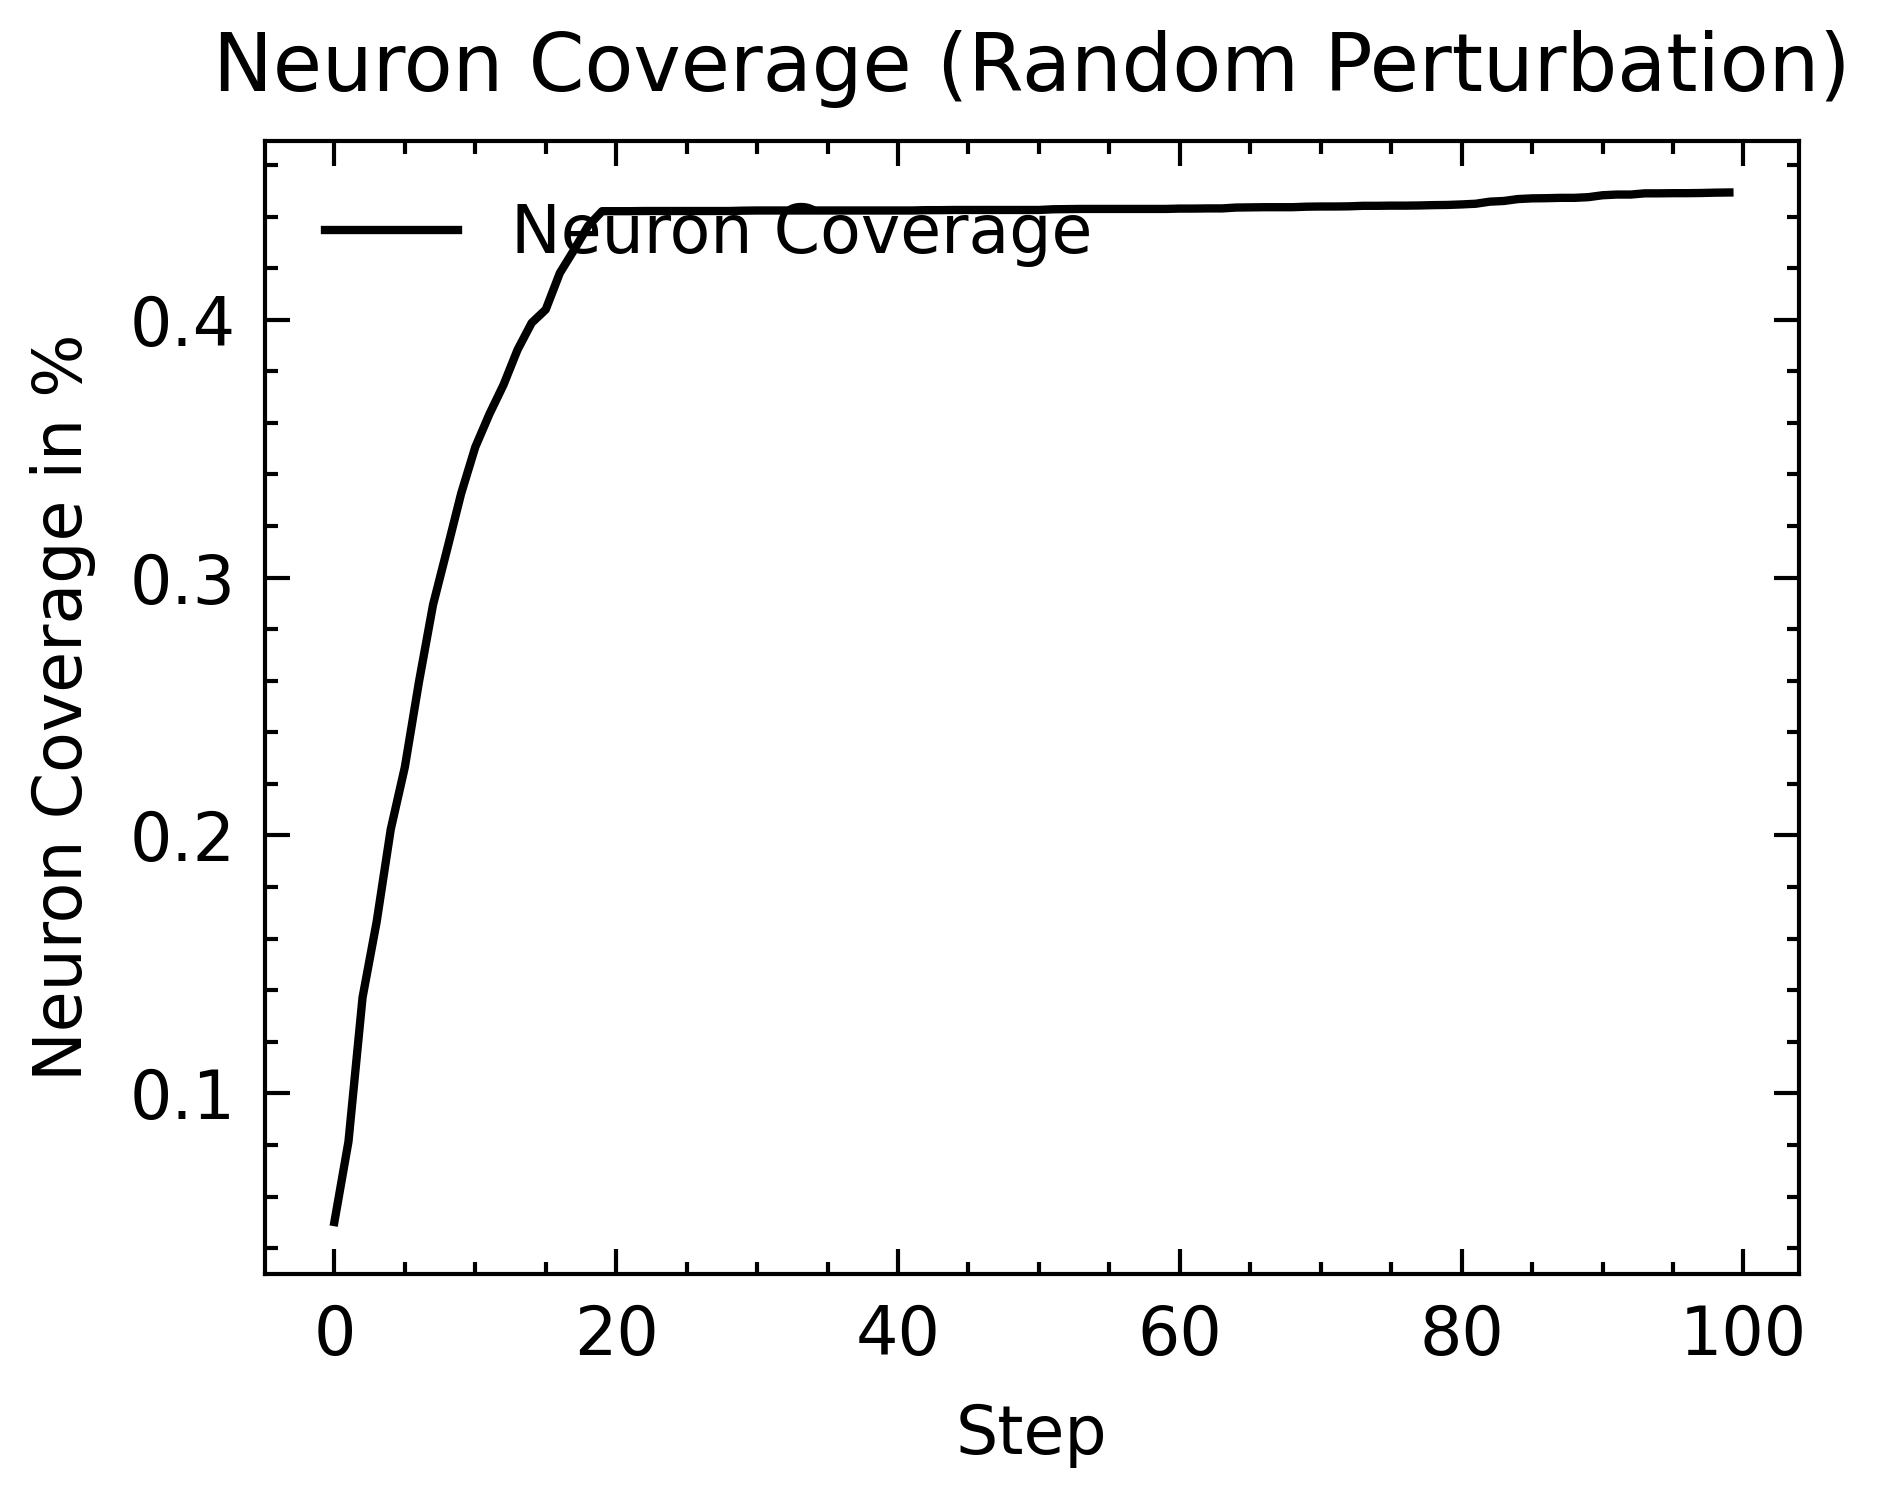

In [75]:
plt.title("Neuron Coverage (Random Perturbation)")
plt.plot(coverage, label="Neuron Coverage")
plt.legend(loc='upper left')
plt.ylabel("Neuron Coverage in %")
plt.xlabel("Step")
plt.show

In [76]:
import json
with open('dlfuzz_random.json', 'w') as fp:
    json.dump(cov_dict, fp)